<a href="https://colab.research.google.com/github/sh-biswas/demand-forecasting_Cogs109Final/blob/master/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)
%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/sh-biswas/demand-forecasting_Cogs109Final/master/train.csv'
data = pd.read_csv(data)

# create arrays to hold parsed year, month, and day
years = np.empty(data.shape[0]).astype('int32')
months = np.empty(data.shape[0]).astype('int32')
days = np.empty(data.shape[0]).astype('int32')
#print(f"len(years): {len(years)}")

# parse "year", "month", and "day" from 'date' string
def date_parser(row):
  #print(f"row: \n{row}")
  #print(f"row['date']: {row['date']}")
  year, month, day = tuple(row['date'].split("-"))
  #print(f"year: {year} | month: {month} | day: {day}")
  #print(f"row.name: {row.name}")
  years[row.name] = int(year); months[row.name] = month; days[row.name] = day;
  #print(years[row.name])

# call parser on all rows
data.apply(date_parser, axis=1)

# add "year", "month", and "day" columns to data
data['year'] = years
data['month'] = months
data['day'] = days


# separate out train and test data
data = data.sort_values(by = ['date'])
print(f"first test date: {data['date'].unique()[-90]}")
test = data[-45000:][data[-45000:]['item'] == 15]
train = data[:-45000][data[:-45000]['item'] == 15]
#print(f"length of train: {len(train)}")
#print(f"num train dates: {len(train['date'].unique())}")


first test date: 2017-10-03


In [3]:
print(f"THESE SHOULD BE THE SAME: \n{len(years)}\n{len(data.index)}")

THESE SHOULD BE THE SAME: 
913000
913000


In [4]:
train.head()

,date,store,item,sales,year,month,day
255640,2013-01-01,1,15,42,2013,1,1
257466,2013-01-01,2,15,65,2013,1,1
259292,2013-01-01,3,15,61,2013,1,1
261118,2013-01-01,4,15,46,2013,1,1
262944,2013-01-01,5,15,31,2013,1,1


Check if there are any null values

In [5]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
year     0
month    0
day      0
dtype: int64

In [6]:
test.isnull().sum()

date     0
store    0
item     0
sales    0
year     0
month    0
day      0
dtype: int64

There are no null values in both our test and train datasets.

How many different stores are there in the train dataset?

In [13]:
num_stores = len(data.store.unique())
print(num_stores)

10


How many different items in the train dataset?

In [8]:
num_items = len(train.item.unique())
print(num_items)

1


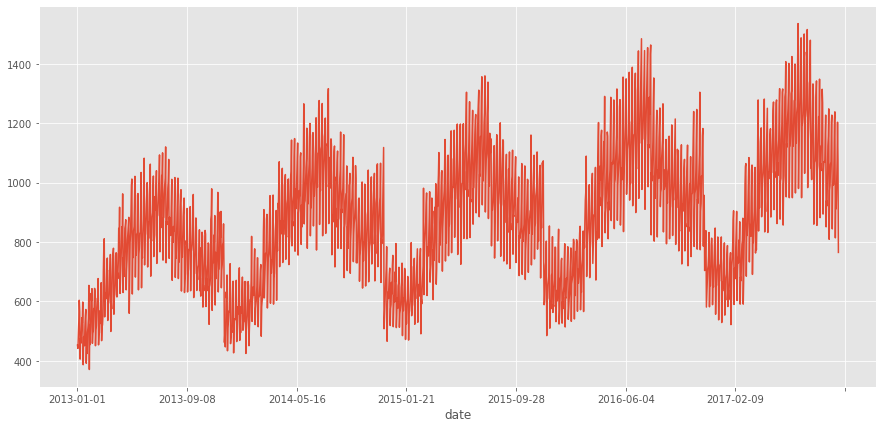

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
train.groupby(['date']).sum()['sales'].plot(ax=ax)

In [14]:
np.argmax(train.groupby(['item']).sum()['sales'])

0

In [15]:
len(train.groupby(['item']).sum()['sales'])

1

In [16]:
# just for store 1 to start
train_store1 = train[ train['store'] == 1]
test_store1 = test[ test['store'] == 1]


# let's do some linear regression!
A = np.vstack((np.ones(len(train_store1)), train_store1['year'], train_store1['month'], train_store1['day'])).T
w = np.linalg.lstsq(A, train_store1['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day")


1st order model: -13283.86 + 6.63*year + 1.32*month + -0.02*day


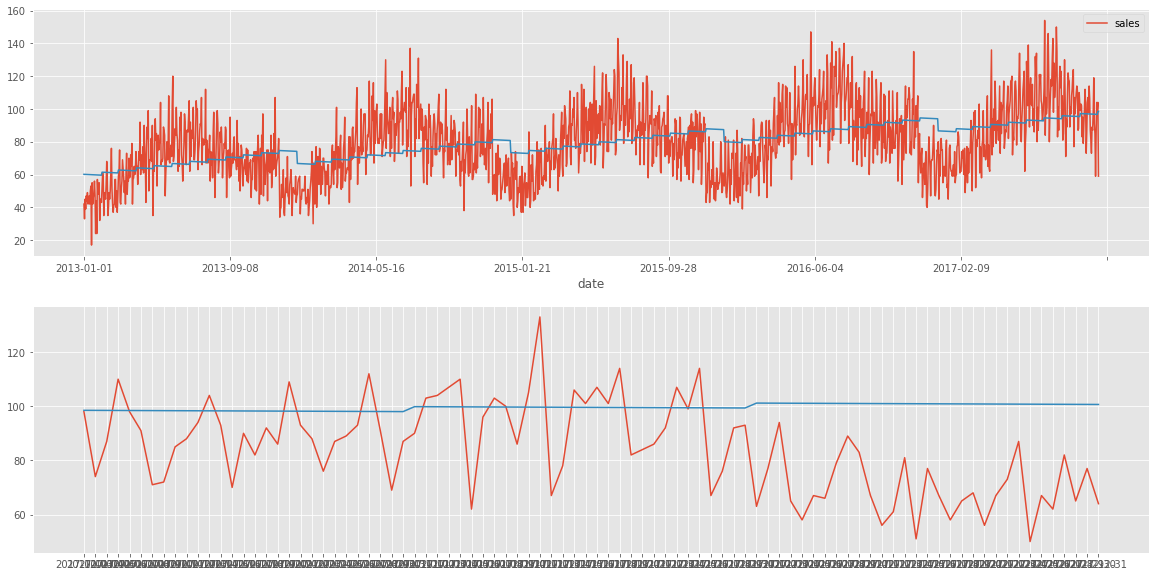

In [17]:
fig, axs = plt.subplots(2,1)
train_store1.plot(x='date', y='sales', figsize=(20,10), ax=axs[0])
axs[1].plot(test_store1['date'].values, test_store1['sales'].values)

## Create a smooth set of Y values for plotting the model
modelYtest = w[0] + w[1]*test_store1['year'].values + w[2]*test_store1['month'].values + w[3]*test_store1['day'].values
modelYtrain = w[0] + w[1]*train_store1['year'].values + w[2]*train_store1['month'].values + w[3]*train_store1['day'].values
axs[1].plot(test_store1['date'].values, modelYtest)
axs[0].plot(train_store1['date'].values, modelYtrain)


Model each item individually for all the stores -> supplier knows how many of each item to distribute over the time span of the test data(supplier perspective)

## First Order Model for All the Stores for Item 15

In [19]:
# let's do some linear regression!
A = np.vstack((np.ones(len(train)), train['year'], train['month'], train['day'])).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day")


1st order model: -14287.85 + 7.13*year + 1.58*month + 0.01*day


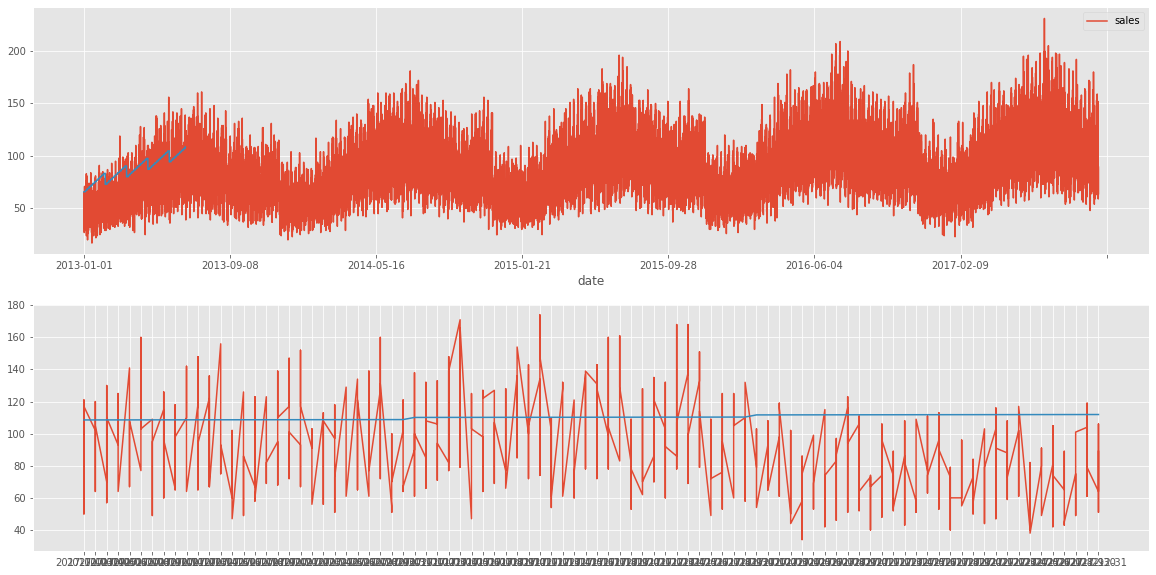

In [20]:
fig, axs = plt.subplots(2,1)
train.plot(x='date', y='sales', figsize=(20,10), ax=axs[0])
axs[1].plot(test['date'].values, test['sales'].values)

## Create a smooth set of Y values for plotting the model
modelYtest_all = w[0] + w[1]*test['year'].values + w[2]*test['month'].values + w[3]*test['day'].values
modelYtrain_all = w[0] + w[1]*train['year'].values + w[2]*train['month'].values + w[3]*train['day'].values
axs[1].plot(test['date'].values, modelYtest_all)
axs[0].plot(train['date'].values, modelYtrain_all)

## Include the store as a term: sales and demands could possibly change model 

In [21]:
# let's do some linear regression!
A = np.vstack((np.ones(len(train)), train['year'], train['month'], train['day'], train['store'])).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day + {w[4]:0.2f}*store")


1st order model: -14287.24 + 7.13*year + 1.58*month + 0.01*day + -0.11*store


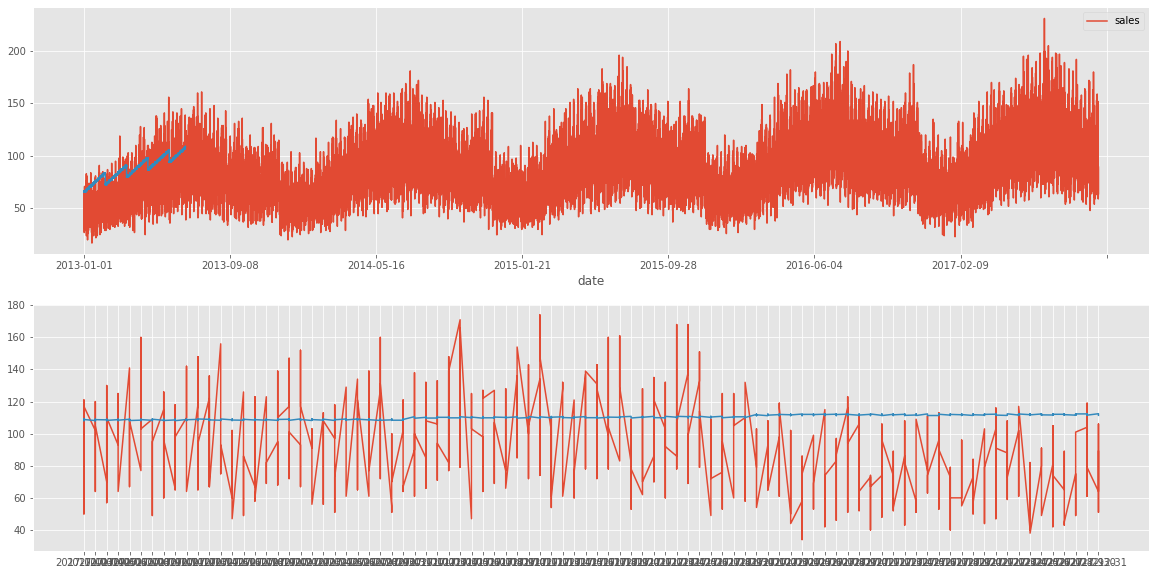

In [22]:
fig, axs = plt.subplots(2,1)
train.plot(x='date', y='sales', figsize=(20,10), ax=axs[0])
axs[1].plot(test['date'].values, test['sales'].values)

## Create a smooth set of Y values for plotting the model
modelYtest = w[0] + w[1]*test['year'].values + w[2]*test['month'].values + w[3]*test['day'].values + w[4]*test['store'].values
modelYtrain = w[0] + w[1]*train['year'].values + w[2]*train['month'].values + w[3]*train['day'].values + w[4]*train['store'].values
axs[1].plot(test['date'].values, modelYtest)
axs[0].plot(train['date'].values, modelYtrain)

## Sixth-Order Multivariate Model: There are 6 bumps and dips in total in our plot of the training data

In [25]:
# let's do some linear regression!
A = np.vstack((np.ones(len(train)), train['year'], train['month'], train['day'], 
               train['store'], (train['year'])**2, (train['year'])**3, (train['year'])**4, 
               (train['year'])**5, (train['year'])**6, (train['month'])**2, 
               (train['month'])**3, (train['month'])**4, (train['month'])**5, 
               (train['month'])**6, (train['day'])**2, (train['day'])**3, 
               (train['day'])**4, (train['day'])**5, (train['day'])**6, (train['store'])**2, 
               (train['store'])**3, (train['store'])**4, (train['store'])**5, 
               (train['store'])**6)).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(len(w))
print(f"6th order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day + {w[4]:0.2f}*store + {w[5]:0.2f}*year^2 + {w[6]:0.2f}*year^3 + {w[7]:0.2f}*year^4 + {w[8]:0.2f}*year^5 + {w[9]:0.2f}*year^6 + {w[10]:0.2f}*month^2 + {w[11]:0.2f}*month^3 + {w[12]:0.2f}*month^4 + {w[13]:0.2f}*month^5 + {w[14]:0.2f}*month^6 + {w[15]:0.2f}*day^2 + {w[16]:0.2f}*day^3 + {w[17]:0.2f}*day^4 + {w[18]:0.2f}*day^5 + {w[19]:0.2f}*day^6 + {w[20]:0.2f}*store^2 + {w[21]:0.2f}*store^3 + {w[22]:0.2f}*store^4 + {w[23]:0.2f}*store^5 + {w[24]:0.2f}*store^6")

25
6th order model: 0.00 + -0.00*year + 61.41*month + 0.81*day + -21.40*store + 0.00*year^2 + 0.00*year^3 + 0.00*year^4 + 0.00*year^5 + -0.00*year^6 + -38.68*month^2 + 12.89*month^3 + -2.05*month^4 + 0.15*month^5 + -0.00*month^6 + -0.25*day^2 + 0.03*day^3 + -0.00*day^4 + 0.00*day^5 + -0.00*day^6 + 62.55*store^2 + -29.97*store^3 + 5.66*store^4 + -0.47*store^5 + 0.01*store^6


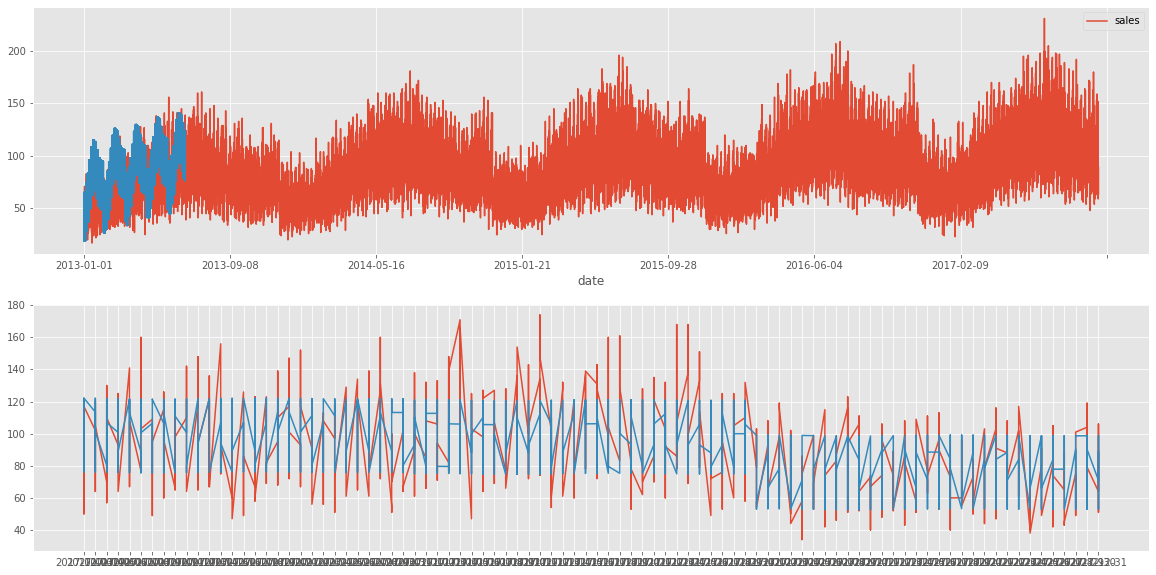

In [27]:
fig, axs = plt.subplots(2,1)
train.plot(x='date', y='sales', figsize=(20,10), ax=axs[0])
axs[1].plot(test['date'].values, test['sales'].values)

## Create a smooth set of Y values for plotting the model
modelYtest = w[0] + w[1]*test['year'].values + w[2]*test['month'].values + w[3]*test['day'].values + w[4]*test['store'].values + w[5]*(test['year'].values**2) + w[6]*(test['year'].values**3) + w[7]*(test['year'].values**4) + w[8]*(test['year'].values**5) + w[9]*(test['year'].values**6) + w[10]*(test['month'].values**2) + w[11]*(test['month'].values**3) + w[12]*(test['month'].values**4) + w[13]*(test['month'].values**5) + w[14]*(test['month'].values**6) + w[15]*(test['day'].values**2) + w[16]*(test['day'].values**3) + w[17]*(test['day'].values**4) + w[18]*(test['day'].values**5) + w[19]*(test['day'].values**6) + w[20]*(test['store'].values**2) + w[21]*(test['store'].values**3) + w[22]*(test['store'].values**4) + w[23]*(test['store'].values**5) + w[24]*(test['store'].values**6)
modelYtrain = w[0] + w[1]*train['year'].values + w[2]*train['month'].values + w[3]*train['day'].values + w[4]*train['store'].values + w[5]*(train['year'].values**2) + w[6]*(train['year'].values**3) + w[7]*(train['year'].values**4) + w[8]*(train['year'].values**5) + w[9]*(train['year'].values**6) + w[10]*(train['month'].values**2) + w[11]*(train['month'].values**3) + w[12]*(train['month'].values**4) + w[13]*(train['month'].values**5) + w[14]*(train['month'].values**6) + w[15]*(train['day'].values**2) + w[16]*(train['day'].values**3) + w[17]*(train['day'].values**4) + w[18]*(train['day'].values**5) + w[19]*(train['day'].values**6) + w[20]*(train['store'].values**2) + w[21]*(train['store'].values**3) + w[22]*(train['store'].values**4) + w[23]*(train['store'].values**5) + w[24]*(train['store'].values**6)
axs[1].plot(test['date'].values, modelYtest)
axs[0].plot(train['date'].values, modelYtrain)